## Overview

Trong notebook này, cho phần build ANN chính mình sẽ sử dụng các thư viện:
- Numpy
- PyTorch


## Import library && data

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor, optim
import numpy as np
import torch.nn.functional as F

In [220]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_data = pd.read_csv("../data/processed/train_normalized.csv")
train_data.dtypes
x = train_data.drop(columns=["Age"])
y = train_data["Age"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

xtrain.shape
ytrain.shape

## Building ANN class

Class này mình sẽ sử dụng Thư viện torch để tạo class và sử dụng hàm hàm kích hoạt Relu từ thư viện này

### Model class

In [221]:
import torch.nn.functional as F

class AgePredictionANN(nn.Module):
    def __init__(self):
        super(AgePredictionANN, self).__init__()
        # fc stand for fully conntection
        self.fc1 = nn.Linear(49,64)
        self.fc2 = nn.Linear(64,16)
        self.fc3 = nn.Linear(16,1)
        
    def forward(self, x):
        inputLayer1 = self.fc1(x)
        activate1 = F.relu(inputLayer1)
        
        outHiddenLayer2 = self.fc2(activate1)
        activate2 = F.relu(outHiddenLayer2)
        
        outputLayer3 = self.fc3(activate2)
        return outputLayer3

In [222]:
model = AgePredictionANN()

In [223]:
model

AgePredictionANN(
  (fc1): Linear(in_features=49, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

### Hàm mất mát và hàm cải tiến

Mục đích hai hàm này là để giúp cải thiện trọng số và bias trong model trong quá trình train model bên dưới

In [224]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Chuyển đổi dữ liệu phù hợp cho việc build model bằng thư viện Pytorch

Bởi vì thư viện Pytorch được xây dựng để build dữ liệu từ tensor - một cấu trúc dữ liệu cơ bản, tương tự như mảng (array):
- Ta sẽ tiến hành đổi dataframe dữ liệu sang numpy
- Từ numpy sẽ dễ dàng hơn để đổi qua tensor

In [225]:
xtrainNumpy = x_train.to_numpy()
ytrainNumpy = y_train.to_numpy()

In [226]:
xtrainNumpy = np.array(x_train, dtype=np.float32)
xTrainTensor = torch.tensor(xtrainNumpy, dtype=torch.float32)
xTrainTensor

tensor([[-0.9096, -0.0940,  2.2463,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0521,  0.3753, -0.8709,  ...,  0.0000,  1.0000,  0.0000],
        [-1.3093,  0.4739, -1.0268,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.0392, -0.6085,  0.0694,  ...,  0.0000,  0.0000,  1.0000],
        [-1.9119,  0.9158, -0.0941,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.6991,  1.4612, -0.2828,  ...,  0.0000,  0.0000,  1.0000]])

In [227]:
yTrainTensor = torch.tensor(ytrainNumpy, dtype=torch.float32)
print("Shape of xTrainTensor:", xTrainTensor.shape)
print("Shape of yTrainTensor:", yTrainTensor.shape)

Shape of xTrainTensor: torch.Size([2400, 49])
Shape of yTrainTensor: torch.Size([2400])


## Build Model

### Giải thích các biến và Cơ chế hoạt động

1. **Biến:**
   - `training_losses`: Danh sách rỗng được dùng để lưu trữ các giá trị mất mát huấn luyện cho mỗi epoch.
   - `loss_history`: Danh sách rỗng để theo dõi các giá trị mất mát qua các epoch nhằm giám sát sự hội tụ.
   - `tolerance`: Một số nguyên được đặt là 5, dùng để xác định số lượng epoch để kiểm tra sự hội tụ.
   - `xTrainTensor`: Một tensor được tạo từ mảng `xTrainNumpy`, với kiểu dữ liệu `torch.float32`. Tensor này đại diện cho các đặc trưng đầu vào cho việc huấn luyện.
   - `yTrainTensor`: Một tensor được tạo từ mảng `yTrainNumpy`, với kiểu dữ liệu `torch.float32`. Tensor này đại diện cho các giá trị mục tiêu cho việc huấn luyện.

2. **Cơ chế hoạt động:**
   - Đoạn mã chạy một vòng huấn luyện trong số lượng epoch được chỉ định (`num_epoch`).
   - Trong mỗi epoch:
     - Mô hình đưa ra dự đoán trên dữ liệu huấn luyện (`xTrainTensor`).
     - Mất mát được tính toán bằng cách sử dụng tiêu chí (hàm mất mát) giữa các giá trị dự đoán và các giá trị mục tiêu thực tế (`yTrainTensor`).
     - Các độ dốc được đặt lại bằng không bằng cách sử dụng `optimizer.zero_grad()`.
     - Mất mát được lan truyền ngược lại bằng `loss.backward()`.
     - Optimizer cập nhật các tham số của mô hình bằng `optimizer.step()`.
     - Giá trị mất mát hiện tại được chuyển đổi thành số float và được thêm vào `loss_history`.
     - Nếu độ dài của `loss_history` lớn hơn 5, mã kiểm tra xem các mất mát gần nhất (số lượng là `tolerance`) có giống nhau không. Nếu chúng giống nhau, nó in ra một thông báo cho biết việc huấn luyện đã hoàn thành và thoát khỏi vòng lặp.
     - Mất mát cho epoch hiện tại được in ra.

Đoạn mã này là một phần của vòng huấn luyện cho một mô hình mạng nơ-ron sử dụng PyTorch. Nó bao gồm các cơ chế để giám sát và có thể dừng việc huấn luyện sớm nếu mất mát không thay đổi đáng kể trong số lượng epoch được chỉ định.

In [228]:

num_epoch = 10000
training_losses = []
loss_history = []
tolerance = 5
for epoch in range(1,num_epoch+1):
    predict = model(xTrainTensor)
    loss = criterion(predict.squeeze(), yTrainTensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss:float = loss.item()
    loss_history.append(round(current_loss, 2))
    if len(loss_history)>5:
        if all(loss_history[-1] == last_loss for last_loss in loss_history[-tolerance-1:-1]):
            print(f"Training completed, Epoch: {epoch}, Final Loss: {current_loss:.4f}")
            break
    print(f'Epoch [{epoch}/{num_epoch}], Loss: {current_loss:.4f}')

Epoch [1/10000], Loss: 1.0981
Epoch [2/10000], Loss: 1.0733
Epoch [3/10000], Loss: 1.0495
Epoch [4/10000], Loss: 1.0270
Epoch [5/10000], Loss: 1.0054
Epoch [6/10000], Loss: 0.9845
Epoch [7/10000], Loss: 0.9642
Epoch [8/10000], Loss: 0.9442
Epoch [9/10000], Loss: 0.9244
Epoch [10/10000], Loss: 0.9047
Epoch [11/10000], Loss: 0.8847
Epoch [12/10000], Loss: 0.8643
Epoch [13/10000], Loss: 0.8435
Epoch [14/10000], Loss: 0.8221
Epoch [15/10000], Loss: 0.8001
Epoch [16/10000], Loss: 0.7773
Epoch [17/10000], Loss: 0.7537
Epoch [18/10000], Loss: 0.7294
Epoch [19/10000], Loss: 0.7042
Epoch [20/10000], Loss: 0.6783
Epoch [21/10000], Loss: 0.6517
Epoch [22/10000], Loss: 0.6245
Epoch [23/10000], Loss: 0.5968
Epoch [24/10000], Loss: 0.5688
Epoch [25/10000], Loss: 0.5404
Epoch [26/10000], Loss: 0.5121
Epoch [27/10000], Loss: 0.4838
Epoch [28/10000], Loss: 0.4558
Epoch [29/10000], Loss: 0.4283
Epoch [30/10000], Loss: 0.4015
Epoch [31/10000], Loss: 0.3756
Epoch [32/10000], Loss: 0.3506
Epoch [33/10000],

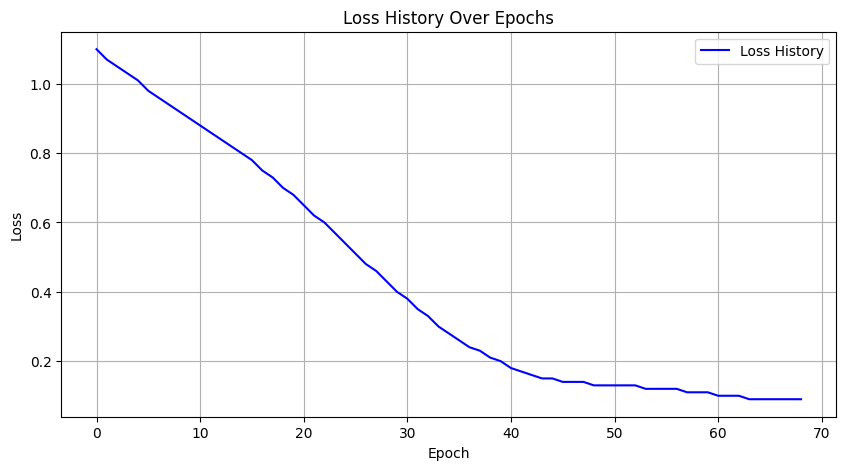

In [229]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))  
plt.plot(loss_history, label='Loss History', color='blue')  
plt.title('Loss History Over Epochs')  
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  
plt.grid()  
plt.show()  

## Asssessing the model

In [234]:

# Chuyển đổi DataFrame sang numpy arrays
X_test_numpy = x_test.to_numpy().astype(np.float32)
y_test_numpy = y_test.to_numpy().astype(np.float32)

# Chuyển đổi numpy arrays sang tensors
X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype=torch.float32)

# Đưa mô hình vào chế độ đánh giá
model.eval()

# Thực hiện dự đoán
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()

# Tính toán các chỉ số đánh giá
criterion = nn.MSELoss()
mse = criterion(predictions, y_test_tensor).item()

mae = nn.L1Loss()
mae_value = mae(predictions, y_test_tensor).item()

print(f"Mean Squared Error (MSE) trên dữ liệu kiểm tra: {mse:.4f}")
print(f"Mean Absolute Error (MAE) trên dữ liệu kiểm tra: {mae_value:.4f}")

Mean Squared Error (MSE) trên dữ liệu kiểm tra: 0.0861
Mean Absolute Error (MAE) trên dữ liệu kiểm tra: 0.2385


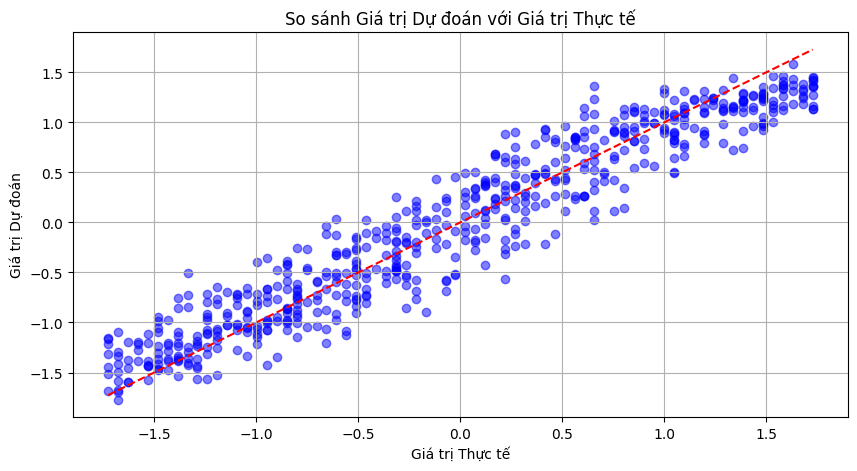

In [232]:
# So sánh dự đoán với giá trị thực tế
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test_numpy, predictions.numpy(), color='blue', alpha=0.5)
plt.plot([y_test_numpy.min(), y_test_numpy.max()], [y_test_numpy.min(), y_test_numpy.max()], 'r--')
plt.xlabel('Giá trị Thực tế')
plt.ylabel('Giá trị Dự đoán')
plt.title('So sánh Giá trị Dự đoán với Giá trị Thực tế')
plt.grid()
plt.show()